In [30]:
from hhparser.scrapper import VacancyScrapper
from hhparser.parser import Parser

params = {
    "clusters": False,
    "ored_clusters": False,
    "enable_snippets": False,
    "salary": None,
    "st": "searchVacancy",
    "text": "rust middle",
    "page": 0
}

scrapper = VacancyScrapper(params = params)
parser = Parser(scrapper = scrapper)
vacancys_data = parser.parse_vacancys(parse_salary=True,parse_date=True)

In [23]:
import pandas as pd

df = pd.DataFrame(columns= list(vacancys_data[0].keys()))

ind = 0
for data in vacancys_data:     
    if (len(df.columns)==len(data)):
        df.loc[ind] = data
        ind+=1

df.to_csv(params["text"]+".csv", encoding="utf8" )

In [24]:
import pandas as pd
df = pd.DataFrame()
#search_text="golang middle"
df=pd.read_csv(params["text"]+".csv", encoding="utf8" )
df

,Unnamed: 0,url,title,salary,company_name,description,company_verified,adress,employment_mode,experience,parttime,accept_temporary,creation-time,tag
0,0,https://ufa.hh.ru/vacancy/51430971,Junior Backend Developer,"{'from': False, 'to': False, 'gross': True, 'c...",ООО Смартфорс,Мы группа разработчиков-энтузиастов SmartForce...,True,"Омск, улица Фрунзе, 80","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['Английский — B1 — Средний', 'Git', 'Linux..."
1,1,https://ufa.hh.ru/vacancy/48726183,Младший Golang разработчик,"{'from': 50000, 'to': 70000, 'gross': False, '...",АО Эшелон Технологии,В нашей расширяющейся команде открыта ваканс...,True,"Москва, Электрозаводская улица, 24","Полная занятость, гибкий график",1–3 года,False,False,2022-01-24,"['Go', 'GoLang', 'NoSQL', 'Базы данных', 'Java..."
2,2,https://ufa.hh.ru/vacancy/50220128,Junior Go разработчик (Core Team),"{'from': 50000, 'to': False, 'gross': False, '...",amoCRM,amoCRM - стабильная и динамично развивающаяся ...,True,"Таганская, Москва, Николоямская улица, 28/60","Полная занятость, полный день",не требуется,False,False,2022-01-25,"['Docker', 'Git', 'Golang', 'Go', 'Backend']"
3,3,https://ufa.hh.ru/vacancy/50950628,IOS разработчик (junior),"{'from': 100000, 'to': False, 'gross': False, ...",ООО Гора Студио,Компания GORA Studio ищет талантливого разрабо...,True,"Спортивная, Чкаловская, Санкт-Петербург, Больш...","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['Swift', 'Xcode', 'Steve Jobs', 'Jira', 'Agil..."
4,4,https://ufa.hh.ru/vacancy/50144902,Junior Backend-разработчик,"{'from': 30000, 'to': 60000, 'gross': False, '...",ООО НЕОСОФТ,"НЕОСОФТ – это российская ИТ-компания, специал...",True,"Самара, Ново-Садовая улица, 44","Полная занятость, гибкий график",1–3 года,False,False,2022-01-26,"['PHP', 'PHP5', 'Golang', 'MySQL', 'HTML', 'CS..."
5,5,https://ufa.hh.ru/vacancy/51715857,Junior Backend-разработчик,"{'from': 50000, 'to': False, 'gross': False, '...",ООО Пауэр Тех,"Мы ищем начинающего специалиста, заинтересован...",True,"Рязань, улица Павлова, 5","Полная занятость, полный день",1–3 года,False,False,2022-01-25,"['Node.js', 'бэкенд', 'SQL', 'Golang']"
6,6,https://ufa.hh.ru/vacancy/51805604,"Junior Full Stack Developer (PL/pgSQL, Go, C)","{'from': False, 'to': False, 'gross': True, 'c...",ООО ЯСП,"ООО ""ЯСП"" – центр внедрения Группы компаний L...",True,"Лиговский проспект, Санкт-Петербург, улица Ко...","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['PostgreSQL', 'ООП', 'SQL', 'Opensource', 'Bi..."
7,7,https://ufa.hh.ru/vacancy/51705997,"Стажёр-разработчик Go, Группа разработки ""Тар...","{'from': False, 'to': False, 'gross': True, 'c...",Ozon Информационные технологии,Начни свою карьеру в Ozon! Хочешь приобрести о...,True,"Деловой центр, Международная, Москва, Преснен...","Стажировка, полный день",не требуется,False,False,2022-01-25,"['PostgreSQL', 'Английский язык', 'Договорна..."
8,8,https://ufa.hh.ru/vacancy/50866957,Junior Backend Developer,"{'from': False, 'to': False, 'gross': True, 'c...",ООО Смартвэй,Кто мы: Smartway - первый разработчик IT реше...,True,"Пенза, Московская улица, 39","Полная занятость, полный день",1–3 года,False,False,2022-01-25,"['MS SQL', 'C#', '.NET Framework', 'ASP.NET', ..."
9,9,https://ufa.hh.ru/vacancy/50748591,Стажер JS+Golang Fullstack,"{'from': False, 'to': False, 'gross': True, 'c...",NIX,Ты получишь отличную теоретическую базу от экс...,NaN,"Харьков, улица Каразина, 2","Стажировка, полный день",не требуется,False,False,2022-01-25,"['Git', 'HTML', 'JavaScript', 'CSS', 'Golang']"


In [25]:
from forex_python.converter import CurrencyRates
import forex_python.converter as fpc
import math
cr = CurrencyRates()

for i in range(len(df.index)):

    if type(df.at[i,"salary"]) == str:
        salary = df.at[i,"salary"]
        
        salary_value = False
        
        if salary["from"] and salary["to"]:
            salary_value = ((salary["from"] or 0) + (salary["to"] or 0))/2
        else:
            salary_value = (salary["from"] or salary["to"]) or False
            
        if salary_value:
            if salary["currancy"]:
                if not(re.search(r'руб.+', salary["currancy"])):
                    try:
                        salary_value = math.floor(cr.convert(salary["currancy"], 'RUB', salary_value))
                        print(salary_value, salary["currancy"])                       
                    except fpc.RatesNotAvailableError:
                        print("Unexpected currancy "+salary["currancy"])
            df.at[i,"salary"] = salary_value

TypeError: string indices must be integers

In [26]:
import pandas as pd

pd.set_option("display.max_rows",None)
display(df)


,Unnamed: 0,url,title,salary,company_name,description,company_verified,adress,employment_mode,experience,parttime,accept_temporary,creation-time,tag
0,0,https://ufa.hh.ru/vacancy/51430971,Junior Backend Developer,"{'from': False, 'to': False, 'gross': True, 'c...",ООО Смартфорс,Мы группа разработчиков-энтузиастов SmartForce...,True,"Омск, улица Фрунзе, 80","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['Английский — B1 — Средний', 'Git', 'Linux..."
1,1,https://ufa.hh.ru/vacancy/48726183,Младший Golang разработчик,"{'from': 50000, 'to': 70000, 'gross': False, '...",АО Эшелон Технологии,В нашей расширяющейся команде открыта ваканс...,True,"Москва, Электрозаводская улица, 24","Полная занятость, гибкий график",1–3 года,False,False,2022-01-24,"['Go', 'GoLang', 'NoSQL', 'Базы данных', 'Java..."
2,2,https://ufa.hh.ru/vacancy/50220128,Junior Go разработчик (Core Team),"{'from': 50000, 'to': False, 'gross': False, '...",amoCRM,amoCRM - стабильная и динамично развивающаяся ...,True,"Таганская, Москва, Николоямская улица, 28/60","Полная занятость, полный день",не требуется,False,False,2022-01-25,"['Docker', 'Git', 'Golang', 'Go', 'Backend']"
3,3,https://ufa.hh.ru/vacancy/50950628,IOS разработчик (junior),"{'from': 100000, 'to': False, 'gross': False, ...",ООО Гора Студио,Компания GORA Studio ищет талантливого разрабо...,True,"Спортивная, Чкаловская, Санкт-Петербург, Больш...","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['Swift', 'Xcode', 'Steve Jobs', 'Jira', 'Agil..."
4,4,https://ufa.hh.ru/vacancy/50144902,Junior Backend-разработчик,"{'from': 30000, 'to': 60000, 'gross': False, '...",ООО НЕОСОФТ,"НЕОСОФТ – это российская ИТ-компания, специал...",True,"Самара, Ново-Садовая улица, 44","Полная занятость, гибкий график",1–3 года,False,False,2022-01-26,"['PHP', 'PHP5', 'Golang', 'MySQL', 'HTML', 'CS..."
5,5,https://ufa.hh.ru/vacancy/51715857,Junior Backend-разработчик,"{'from': 50000, 'to': False, 'gross': False, '...",ООО Пауэр Тех,"Мы ищем начинающего специалиста, заинтересован...",True,"Рязань, улица Павлова, 5","Полная занятость, полный день",1–3 года,False,False,2022-01-25,"['Node.js', 'бэкенд', 'SQL', 'Golang']"
6,6,https://ufa.hh.ru/vacancy/51805604,"Junior Full Stack Developer (PL/pgSQL, Go, C)","{'from': False, 'to': False, 'gross': True, 'c...",ООО ЯСП,"ООО ""ЯСП"" – центр внедрения Группы компаний L...",True,"Лиговский проспект, Санкт-Петербург, улица Ко...","Полная занятость, полный день",1–3 года,False,False,2022-01-26,"['PostgreSQL', 'ООП', 'SQL', 'Opensource', 'Bi..."
7,7,https://ufa.hh.ru/vacancy/51705997,"Стажёр-разработчик Go, Группа разработки ""Тар...","{'from': False, 'to': False, 'gross': True, 'c...",Ozon Информационные технологии,Начни свою карьеру в Ozon! Хочешь приобрести о...,True,"Деловой центр, Международная, Москва, Преснен...","Стажировка, полный день",не требуется,False,False,2022-01-25,"['PostgreSQL', 'Английский язык', 'Договорна..."
8,8,https://ufa.hh.ru/vacancy/50866957,Junior Backend Developer,"{'from': False, 'to': False, 'gross': True, 'c...",ООО Смартвэй,Кто мы: Smartway - первый разработчик IT реше...,True,"Пенза, Московская улица, 39","Полная занятость, полный день",1–3 года,False,False,2022-01-25,"['MS SQL', 'C#', '.NET Framework', 'ASP.NET', ..."
9,9,https://ufa.hh.ru/vacancy/50748591,Стажер JS+Golang Fullstack,"{'from': False, 'to': False, 'gross': True, 'c...",NIX,Ты получишь отличную теоретическую базу от экс...,NaN,"Харьков, улица Каразина, 2","Стажировка, полный день",не требуется,False,False,2022-01-25,"['Git', 'HTML', 'JavaScript', 'CSS', 'Golang']"


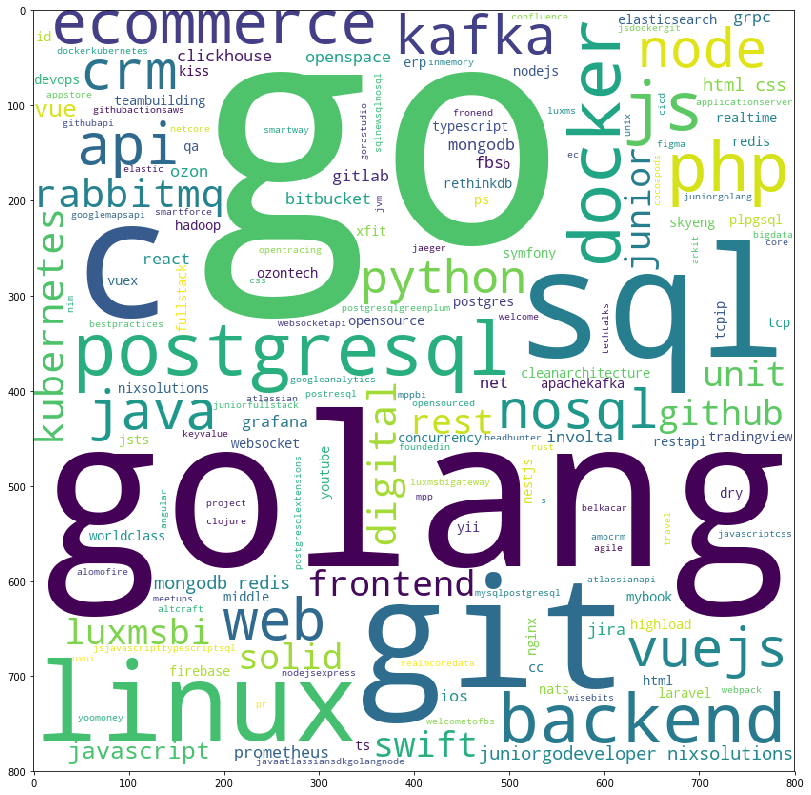

In [28]:
from collections import Counter
import scipy

vacancy_names = df.tag # change here to change source of data/words etc


descriptions = df.description

import re

additional_tegs = []

for dsc in descriptions:
    searched = re.findall(r"(([A-z]+[\s/-]*)+)+", dsc)
    for pair in searched: 
        addteg = list(pair)[0]
        addteg = re.sub(r'\s+|\W+','', addteg)
        addteg = addteg.lower() 
        additional_tegs.append(addteg)

#print(additional_tegs)        
    
all_tags = []
for tag in vacancy_names:
    all_tags.append("".join(tag)) 



from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(additional_tegs):
    cloud+=x+' '

wordcloud = WordCloud(width = 800, height = 800, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (14, 14)) 
plt.imshow(wordcloud)
plt.savefig('vacancy_cloud.png')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


9 3.0
6 3.0
11 3.0
15 3.0
44 3.0
242 3.0


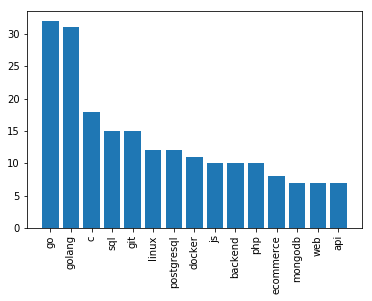

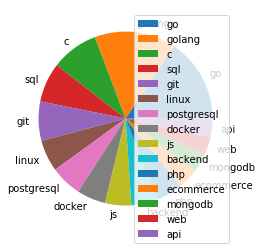

In [29]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))



ps = PorterStemmer()
stemmed_words=[]


for w in additional_tegs:
    words = word_tokenize(w)
    for wd in words: 
        if wd not in stop_words:
            stemmed_words.append(wd)
    
#print(stemmed_words)


additional_tegs=stemmed_words
teg_frequencys = Counter(additional_tegs)
teg_frequencys = dict(teg_frequencys)

new_series = pd.Series(data=list(teg_frequencys), index=list(teg_frequencys.values()))
new_series=new_series.sort_index(ascending=False)

freq = dict(Counter(list(new_series.index)))
freq_values = list(freq.values())
freq_values.sort(reverse=True)

freq_median = scipy.median(freq_values)

new_index = []
for ind in list(freq):     
        if freq[ind]>scipy.median(freq_values):
            print(freq[ind],scipy.median(freq_values))
            new_index.append(ind)

          
        
#print(freq,"median",freq_values,freq_median,"mean",scipy.mean(freq_values),new_index)
new_series=new_series.drop(new_index)
#print(new_series)

from matplotlib import pyplot as plt

plt.figure()
plt.xticks(rotation='vertical')
plt.bar(new_series.values, new_series.index)
plt.show()


patches, texts = plt.pie(new_series.index, labels = new_series.values)
plt.legend(patches, new_series.values, loc="best")
plt.show()

In [144]:
! git add *
! git commit -m "some ambitious"
! git push 

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[main d9dc791] some changes
 5 files changed, 51481 insertions(+), 10161 deletions(-)
 rewrite .ipynb_checkpoints/main-checkpoint.ipynb (70%)
 create mode 100644 unity3d.csv
 rewrite vacancy_cloud.png (95%)
 create mode 100644 "\321\201++ middle.csv"


remote: This repository moved. Please use the new location:        
remote:   https://github.com/LuaSavage/hh_ru_parser.git        
To https://github.com/russianSlave/hh_ru_parser.git
   fb3c89d..d9dc791  main -> main
